In [2]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from math import log2
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pylab as plt

## Hyperparameters
- Initialize the DATASET by the path of the real images.
- Specify the start train at image size 8x8.
- Initialize the device by Cuda if it is available and CPU otherwise, and learning rate by 0.001.
- The batch size will be different depending on the resolution of the images that we want to generate, so we initialize BATCH_SIZES by a list of numbers, you can change them depending on your VRAM.
- Initialize image_size by 128 and CHANNELS_IMG by 3 because we will generate 128  by 128 RGB images.
- In the original paper, they initialize Z_DIM, W_DIM, and IN_CHANNELS by 512, but I initialize them by 256 instead for less VRAM usage and speed-up training. We could perhaps even get better results if we doubled them.
- For StyleGAN we can use any of the GANs loss functions we want, so I use WGAN-GP from the paper Improved Training of Wasserstein GANs. This loss contains a parameter name λ and it's common to set λ = 10.
- Initialize PROGRESSIVE_EPOCHS by 30 for each image size.

In [3]:
DATSET = 'Root'
START_TRAIN_IMG_SIZE = 4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LR = 1e-3
BATCH_SIZES = [256,256,128,64,32,16]
CHANNELS_IMG = 3
Z_DIM = 512
W_DIM = 512
IN_CHANNELS = 512
LAMBDA_GP = 10
PROGRESSIVE_EPOCHS = [30] * len(BATCH_SIZES)

## Get data loader
- Apply some transformation to the images (resize the images to the resolution that we want, convert them to tensors, then apply some augmentation, and finally normalize them to be all the pixels ranging from -1 to 1).
- Identify the current batch size using the list BATCH_SIZES, and take as an index the integer number of the inverse representation of the power of 2 of image_size/4. And this is actually how we implement the adaptive minibatch size depending on the output resolution.
- Prepare the dataset by using ImageFolder because it's already structured in a nice way.
- Create mini-batch sizes using DataLoader that take the dataset and batch size with shuffling the data.
- Finally, return the loader and dataset.

In [4]:
def get_loader(image_size):
    trainsform = transforms.Compose(
        [transforms.Resize((image_size, image_size)),
         transforms.ToTensor(),
         transforms.RandomHorizontalFlip(p=0.5),
         transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)],
            [0.5 for _ in range(CHANNELS_IMG)],
         )
        ]
    )
    batch_size = BATCH_SIZES[int(log2(image_size/4))]
    dataset = datasets.ImageFolder(root=DATSET, transform=trainsform)
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True
    )
    return loader, dataset

## Models implementation
the key points:

- Noise Mapping Network
- Adaptive Instance Normalization (AdaIN)
- Progressive growing

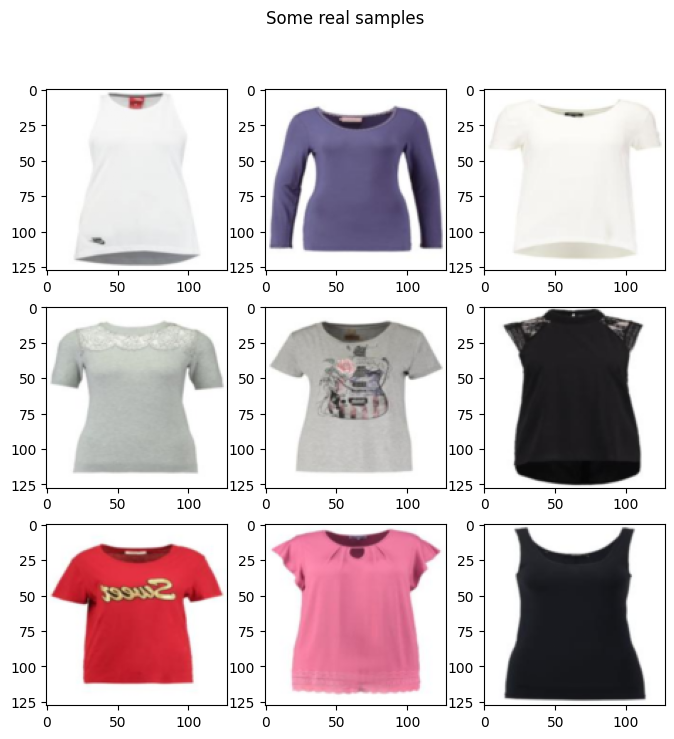

In [5]:
def check_loader():
    loader,_ = get_loader(128)
    cloth,_  = next(iter(loader))
    _,ax     = plt.subplots(3,3,figsize=(8,8))
    plt.suptitle('Some real samples')
    ind = 0
    for k in range(3):
        for kk in range(3):
            ax[k][kk].imshow((cloth[ind].permute(1,2,0)+1)/2)
            ind +=1
check_loader() 

Let's define a variable with the name factors that contain the numbers that will multiply with IN_CHANNELS to have the number of channels that we want in each image resolution.

In [6]:

factors = [1,1,1,1/2,1/4,1/8,1/16,1/32]

##### And don't forget to equalize the learning rate as we do in ProGAN.

In [7]:
class WSLinear(nn.Module):
    def __init__(
        self, in_features, out_features
    ):
        super(WSLinear,self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.scale  = (2/in_features) ** 0.5
        self.bias   = self.linear.bias
        self.linear.bias = None

        nn.init.normal_(self.linear.weight)
        nn.init.zeros_(self.bias)

    def forward(self,x):
        return self.linear(x * self.scale) + self.bias 

In [8]:
class PixenNorm(nn.Module):
    def __init__(self):
        super(PixenNorm, self).__init__()
        self.epsilon = 1e-8
    def forward(self,x ):
        return x / torch.sqrt(torch.mean(x**2, dim=1, keepdim=True)+  self.epsilon)

#### Now let's create the MappingNetwork class.
In the init part we send z_dim and w_din, and we define the network mapping that first normalizes z_dim, followed by eight of WSLInear and ReLU as activation functions.
In the forward part, we return the network mapping.


<img src="https://blog.paperspace.com/content/images/2022/09/image-2-1.png" alt="Description of the image">


In [30]:
class MappingNetwork(nn.Module):
    def __init__(self, z_dim, w_dim):
        super().__init__()
        self.mapping = nn.Sequential(
            PixenNorm(),
            WSLinear(z_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
        )
    
    def forward(self,x):
        return self.mapping(x)

# Adaptive Instance Normalization (AdaIN)
In the init part we send channels, w_dim, and we initialize instance_norm which will be the instance normalization part, and we initialize style_scale and style_bias which will be the adaptive parts with WSLinear that maps the Noise Mapping Network W into channels.
In the forward pass, we send x, apply instance normalization for it, and return style_sclate * x + style_bias.


<img src="https://blog.paperspace.com/content/images/size/w1000/2022/09/image-14.png" alt="Description of the image">


In [31]:
class AdaIN(nn.Module):
    def __init__(self, channels, w_dim):
        super().__init__()
        self.instance_norm = nn.InstanceNorm2d(channels)
        self.style_scale   = WSLinear(w_dim, channels)
        self.style_bias    = WSLinear(w_dim, channels)

    def forward(self,x,w):
        x = self.instance_norm(x)
        style_scale = self.style_scale(w).unsqueeze(2).unsqueeze(3)
        style_bias  = self.style_bias(w).unsqueeze(2).unsqueeze(3)
        return style_scale * x + style_bias

## Inject Noise
Now let's create the class InjectNoise to inject the noise into the generator

In the init part we sent channels and we initialize weight from a random normal distribution and we use nn.Parameter so that these weights can be optimized
In the forward part, we send an image x and we return it with random noise added

In [32]:
class injectNoise(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros(1,channels,1,1))

    def forward(self, x):
        noise = torch.randn((x.shape[0], 1, x.shape[2], x.shape[3]), device = x.device)
        return x + self.weight + noise

## Generator
In the generator architecture, we have some patterns that repeat so let's first create a class for it to make our code as clean as possible, let's name the class GenBlock which will be inherited from nn.Module.

In the init part we send in_channels, out_channels, and w_dim, then we initialize conv1 by WSConv2d which maps in_channels to out_channels, conv2 by WSConv2d which maps out_channels to out_channels, leaky by Leaky ReLU with a slope of 0.2 as they use in the paper, inject_noise1, inject_noise2 by the InjectNoise, adain1, and adain2 by AdaIN
In the forward part, we send x, and we pass it to conv1 then to inject_noise1 with leaky, then we normalize it with adain1, and again we pass that into conv2 then to inject_noise2 with leaky and we normalize it with adain2. And finally, we return x.

In [33]:
class GenBlock(nn.Module):
    def __init__(self, in_channel, out_channel, w_dim):
        super(GenBlock, self).__init__()
        self.conv1 = WSConv2d(in_channel, out_channel)
        self.conv2 = WSConv2d(out_channel, out_channel)
        self.leaky = nn.LeakyReLU(0.2, inplace=True)
        self.inject_noise1 = injectNoise(out_channel)
        self.inject_noise2 = injectNoise(out_channel)
        self.adain1 = AdaIN(out_channel, w_dim)
        self.adain2 = AdaIN(out_channel, w_dim)

        
    def forward(self, x,w):
        x = self.adain1(self.leaky(self.inject_noise1(self.conv1(x))), w)
        x = self.adain2(self.leaky(self.inject_noise2(self.conv2(x))), w)
        return x

<img src="https://blog.paperspace.com/content/images/2022/09/image-15.png" alt="Description of the image">


in the init part let's initialize 'starting_constant' by constant 4 x 4 (x 512 channel for the original paper, and  256 in our case) tensor which is put through an iteration of the generator, map by 'MappingNetwork', initial_adain1, initial_adain2 by AdaIN, initial_noise1, initial_noise2 by InjectNoise, initial_conv by a conv layer that map in_channels to itself, leaky by Leaky ReLU with a slope of 0.2, initial_rgb by WSConv2d that maps in_channels to img_channels wi=hich is 3 for RGB, prog_blocks by ModuleList() that will contain all the progressive blocks (we indicate convolution input/output channels by multiplicate in_channels which is 512 in paper and 256 in our case with factors), and rgb_blocks by ModuleList() that will contain all the RGB blocks.
To fade in new layers (an origin component of ProGAN), we add the fade_in part, which we send alpha, scaled, and generated, and we return  
tanh(alpha∗generated+(1−alpha)∗upscale)
, The reason why we use tanh is that will be the output(the generated image) and we want the pixels to be range between 1 and -1.
In the forward part, we send the noise (Z_dim),  the alpha value which is going to fade in slowly during training (alpha is between 0 and 1), and steps which is the number of the current resolution that we are working with, we pass x into the map to get the intermediate noise vector W, we pass starting_constant to initial_noise1, apply for it and for W initial_adain1, then we passe it into initial_conv,  and again we add initial_noise2 for it with leaky as activation function, and apply for it and W initial_adain2. Then we check if steps = 0 if it is, then all we want to do is run it through the initial RGB and we have done, otherwise, we loop over the number of steps, and in each loop we upscaling(upscaled) and we run through the progressive block that corresponds to that resolution(out). In the end, we return fade_in that takes alpha, final_out, and final_upscaled after mapping it to RGB.

In [34]:
class Generator(nn.Module):
    def __init__(self, z_dim, w_dim, in_channels, img_channels=3):
        super().__init__()
        self.starting_cte = nn.Parameter(torch.ones(1, in_channels, 4,4))
        self.map = MappingNetwork(z_dim, w_dim)
        self.initial_adain1 = AdaIN(in_channels, w_dim)
        self.initial_adain2 = AdaIN(in_channels, w_dim)
        self.initial_noise1 = injectNoise(in_channels)
        self.initial_noise2 = injectNoise(in_channels)
        self.initial_conv   = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
        self.leaky          = nn.LeakyReLU(0.2, inplace=True)

        self.initial_rgb    = WSConv2d(
            in_channels, img_channels, kernel_size = 1, stride=1, padding=0
        )
        self.prog_blocks, self.rgb_layers = (
            nn.ModuleList([]),
            nn.ModuleList([self.initial_rgb])
        )

        for i in range(len(factors)-1):
            conv_in_c  = int(in_channels * factors[i])
            conv_out_c = int(in_channels * factors[i+1])
            self.prog_blocks.append(GenBlock(conv_in_c, conv_out_c, w_dim))
            self.rgb_layers.append(WSConv2d(conv_out_c, img_channels, kernel_size = 1, stride=1, padding=0))
        
    def fade_in(self, alpha, upscaled, generated):
        return nn.tanh(alpha * generated + 1-alpha *upscaled )

    def forward(self, noise, alpha, steps):
        w = self.map(noise)
        x = self.initial_adain1(self.initial_noise1(self.starting_cte),w)
        x = self.initial_conv(x)
        out = self.initial_adain2(self.leaky(self.initial_noise2(x)), w)

        if steps == 0:
            return self.initial_rgb(x)
        
        for step in range(steps):
            upscaled = F.interpolate(out, scale_factor=2, mode = 'bilinear')
            out      = self.prog_blocks[step](upscaled,w)

        final_upscaled = self.rgb_layers[steps-1](upscaled)
        final_out      = self.rgb_layers[steps](out)

        return self.fade_in(alpha, final_upscaled, final_out)

In [35]:
class WSConv2d(nn.Module):
    def __init__(
        self, in_channels, out_channels, kernel_size=3, stride=1, padding=1
    ):
        super(WSConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale = (2 / (in_channels * (kernel_size ** 2))) ** 0.5
        self.bias = self.conv.bias
        self.conv.bias = None

        # initialize conv layer
        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        # -------------------------------------------------------------------------------------------

In [36]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = WSConv2d(in_channels, out_channels)
        self.conv2 = WSConv2d(out_channels, out_channels)
        self.leaky = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.leaky(self.conv1(x))
        x = self.leaky(self.conv2(x))
        return x

# Discriminator is the same as in ProGAN.

In [37]:
class Discriminator(nn.Module):
    def __init__(self, in_channels, img_channels=3):
        super(Discriminator, self).__init__()
        self.prog_blocks, self.rgb_layers = nn.ModuleList([]), nn.ModuleList([])
        self.leaky = nn.LeakyReLU(0.2)

        # here we work back ways from factors because the discriminator
        # should be mirrored from the generator. So the first prog_block and
        # rgb layer we append will work for input size 1024x1024, then 512->256-> etc
        for i in range(len(factors) - 1, 0, -1):
            conv_in = int(in_channels * factors[i])
            conv_out = int(in_channels * factors[i - 1])
            self.prog_blocks.append(ConvBlock(conv_in, conv_out))
            self.rgb_layers.append(
                WSConv2d(img_channels, conv_in, kernel_size=1, stride=1, padding=0)
            )

        # perhaps confusing name "initial_rgb" this is just the RGB layer for 4x4 input size
        # did this to "mirror" the generator initial_rgb
        self.initial_rgb = WSConv2d(
            img_channels, in_channels, kernel_size=1, stride=1, padding=0
        )
        self.rgb_layers.append(self.initial_rgb)
        self.avg_pool = nn.AvgPool2d(
            kernel_size=2, stride=2
        )  # down sampling using avg pool

        # this is the block for 4x4 input size
        self.final_block = nn.Sequential(
            # +1 to in_channels because we concatenate from MiniBatch std
            WSConv2d(in_channels + 1, in_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=4, padding=0, stride=1),
            nn.LeakyReLU(0.2),
            WSConv2d(
                in_channels, 1, kernel_size=1, padding=0, stride=1
            ),  # we use this instead of linear layer
        )

    def fade_in(self, alpha, downscaled, out):
        """Used to fade in downscaled using avg pooling and output from CNN"""
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return alpha * out + (1 - alpha) * downscaled

    def minibatch_std(self, x):
        batch_statistics = (
            torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
        )
        # we take the std for each example (across all channels, and pixels) then we repeat it
        # for a single channel and concatenate it with the image. In this way the discriminator
        # will get information about the variation in the batch/image
        return torch.cat([x, batch_statistics], dim=1)

    def forward(self, x, alpha, steps):
        # where we should start in the list of prog_blocks, maybe a bit confusing but
        # the last is for the 4x4. So example let's say steps=1, then we should start
        # at the second to last because input_size will be 8x8. If steps==0 we just
        # use the final block
        cur_step = len(self.prog_blocks) - steps

        # convert from rgb as initial step, this will depend on
        # the image size (each will have it's on rgb layer)
        out = self.leaky(self.rgb_layers[cur_step](x))

        if steps == 0:  # i.e, image is 4x4
            out = self.minibatch_std(out)
            return self.final_block(out).view(out.shape[0], -1)

        # because prog_blocks might change the channels, for down scale we use rgb_layer
        # from previous/smaller size which in our case correlates to +1 in the indexing
        downscaled = self.leaky(self.rgb_layers[cur_step + 1](self.avg_pool(x)))
        out = self.avg_pool(self.prog_blocks[cur_step](out))

        # the fade_in is done first between the downscaled and the input
        # this is opposite from the generator
        out = self.fade_in(alpha, downscaled, out)

        for step in range(cur_step + 1, len(self.prog_blocks)):
            out = self.prog_blocks[step](out)
            out = self.avg_pool(out)

        out = self.minibatch_std(out)
        return self.final_block(out).view(out.shape[0], -1)

## Utils
In the code snippet below you can find the generate_examples function that takes the generator gen, the number of steps to identify the current resolution, and a number n=100. The goal of this function is to generate n fake images and save them as a result.

In [38]:
def generate_examples(gen, steps, n=100):

    gen.eval()
    alpha = 1.0
    for i in range(n):
        with torch.no_grad():
            noise = torch.randn(1, Z_DIM).to(DEVICE)
            img = gen(noise, alpha, steps)
            if not os.path.exists(f'saved_examples_Style/step{steps}'):
                os.makedirs(f'saved_examples_Style/step{steps}')
            save_image(img*0.5+0.5, f"saved_examples_Style/step{steps}/img_{i}.png")
    gen.train()

In [39]:
def gradient_penalty(critic, real, fake, alpha, train_step, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    beta = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * beta + fake.detach() * (1 - beta)
    interpolated_images.requires_grad_(True)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, alpha, train_step)
 
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

In [40]:
def train_fn(
    critic,
    gen,
    loader,
    dataset,
    step,
    alpha,
    opt_critic,
    opt_gen
):
    loop = tqdm(loader, leave=True)

    for batch_idx, (real, _) in enumerate(loop):
        real = real.to(DEVICE)
        cur_batch_size = real.shape[0]
        noise = torch.randn(cur_batch_size, Z_DIM).to(DEVICE)
        fake  = gen(noise, alpha, step)
        critic_real = critic(real, alpha, step)
        critic_fake = critic(fake.detach(), alpha, step)
        gp = gradient_penalty(critic, real, fake, alpha, step, DEVICE)
        loss_critic = (
            -(torch.mean(critic_real) - torch.mean(critic_fake))
            + LAMBDA_GP * gp
            + (0.001) * torch.mean(critic_real ** 2)
        )

        critic.zero_grad()
        loss_critic.backward()
        opt_critic.step()

        gen_fake = critic(fake, alpha, step)
        loss_gen = -torch.mean(gen_fake)

        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        alpha += cur_batch_size / (
            PROGRESSIVE_EPOCHS[step] * 0.5 * len(dataset)
        )
        alpha = min(alpha,1)


        loop.set_postfix(
            gp = gp.item(),
            loss_critic = loss_critic.item()
        )
    return alpha

In [41]:
gen = Generator(
    Z_DIM, W_DIM, IN_CHANNELS, CHANNELS_IMG
).to(DEVICE)
critic = Discriminator(IN_CHANNELS, CHANNELS_IMG).to(DEVICE)
opt_gen = optim.Adam([{'params': [param for name, param in gen.named_parameters() if 'map' not in name]},
                     {'params': gen.map.parameters(), 'lr': 1e-5}], lr=LR, betas =(0.0, 0.99))
opt_critic = optim.Adam(
    critic.parameters(), lr= LR, betas =(0.0, 0.99)
)

gen.train()
critic.train()
step = int(log2(START_TRAIN_IMG_SIZE / 4))
for num_epochs in PROGRESSIVE_EPOCHS[step:]:
    alpha = 1e-7
    loader, dataset = get_loader(4*2**step)
    print('Curent image size: '+str(4*2**step))

    for epoch in range(num_epochs):
        print(f'Epoch [{epoch + 1}/ {num_epochs}')
        alpha = train_fn(
            critic, gen, loader, dataset, step, alpha, opt_critic, opt_gen
        )
    generate_examples(gen, step)
    step +=1


Curent image size: 4
Epoch [1/ 30


  0%|          | 0/64 [00:00<?, ?it/s]

100%|██████████| 64/64 [00:16<00:00,  3.81it/s, gp=2.94, loss_critic=-26.4]   


Epoch [2/ 30


100%|██████████| 64/64 [00:16<00:00,  3.91it/s, gp=1.11, loss_critic=-8.02]


Epoch [3/ 30


100%|██████████| 64/64 [00:17<00:00,  3.60it/s, gp=0.562, loss_critic=-12.2]


Epoch [4/ 30


100%|██████████| 64/64 [00:17<00:00,  3.72it/s, gp=0.504, loss_critic=-15.1]


Epoch [5/ 30


100%|██████████| 64/64 [00:18<00:00,  3.47it/s, gp=0.611, loss_critic=-20.9]


Epoch [6/ 30


100%|██████████| 64/64 [00:18<00:00,  3.42it/s, gp=0.577, loss_critic=-16.4]


Epoch [7/ 30


100%|██████████| 64/64 [00:18<00:00,  3.51it/s, gp=0.452, loss_critic=-10.6]


Epoch [8/ 30


100%|██████████| 64/64 [00:18<00:00,  3.41it/s, gp=0.438, loss_critic=-14.3]


Epoch [9/ 30


100%|██████████| 64/64 [00:18<00:00,  3.42it/s, gp=0.358, loss_critic=-8.81]


Epoch [10/ 30


100%|██████████| 64/64 [00:18<00:00,  3.51it/s, gp=0.3, loss_critic=-9.35]  


Epoch [11/ 30


100%|██████████| 64/64 [00:18<00:00,  3.50it/s, gp=0.14, loss_critic=-4.01] 


Epoch [12/ 30


100%|██████████| 64/64 [00:18<00:00,  3.40it/s, gp=0.137, loss_critic=-5.28] 


Epoch [13/ 30


100%|██████████| 64/64 [00:18<00:00,  3.52it/s, gp=0.201, loss_critic=-7.17]


Epoch [14/ 30


100%|██████████| 64/64 [00:19<00:00,  3.36it/s, gp=0.314, loss_critic=-10.9]


Epoch [15/ 30


100%|██████████| 64/64 [00:19<00:00,  3.36it/s, gp=0.272, loss_critic=-11.3]


Epoch [16/ 30


100%|██████████| 64/64 [00:18<00:00,  3.42it/s, gp=0.258, loss_critic=-11.2]


Epoch [17/ 30


100%|██████████| 64/64 [00:18<00:00,  3.39it/s, gp=0.296, loss_critic=-10.9]


Epoch [18/ 30


100%|██████████| 64/64 [00:18<00:00,  3.52it/s, gp=0.137, loss_critic=-6.54]


Epoch [19/ 30


100%|██████████| 64/64 [00:18<00:00,  3.41it/s, gp=0.111, loss_critic=-4.24] 


Epoch [20/ 30


100%|██████████| 64/64 [00:18<00:00,  3.52it/s, gp=0.36, loss_critic=-11.9] 


Epoch [21/ 30


100%|██████████| 64/64 [00:18<00:00,  3.54it/s, gp=0.101, loss_critic=-5.94] 


Epoch [22/ 30


100%|██████████| 64/64 [00:19<00:00,  3.33it/s, gp=0.0974, loss_critic=-6.07]


Epoch [23/ 30


100%|██████████| 64/64 [00:19<00:00,  3.24it/s, gp=0.0758, loss_critic=-6.57]


Epoch [24/ 30


100%|██████████| 64/64 [00:19<00:00,  3.29it/s, gp=0.064, loss_critic=-4.74] 


Epoch [25/ 30


100%|██████████| 64/64 [00:18<00:00,  3.40it/s, gp=0.257, loss_critic=0.227] 


Epoch [26/ 30


100%|██████████| 64/64 [00:18<00:00,  3.47it/s, gp=0.0369, loss_critic=-1.13]  


Epoch [27/ 30


100%|██████████| 64/64 [00:18<00:00,  3.46it/s, gp=0.0373, loss_critic=-1.73]


Epoch [28/ 30


100%|██████████| 64/64 [00:19<00:00,  3.35it/s, gp=0.0461, loss_critic=-2.84]


Epoch [29/ 30


100%|██████████| 64/64 [00:19<00:00,  3.33it/s, gp=0.0448, loss_critic=-2.4] 


Epoch [30/ 30


100%|██████████| 64/64 [00:18<00:00,  3.38it/s, gp=0.063, loss_critic=-3.96] 


Curent image size: 8
Epoch [1/ 30


100%|██████████| 64/64 [00:53<00:00,  1.20it/s, gp=0.0163, loss_critic=0.784]  


Epoch [2/ 30


100%|██████████| 64/64 [00:54<00:00,  1.17it/s, gp=0.0153, loss_critic=-2.65]  


Epoch [3/ 30


100%|██████████| 64/64 [00:54<00:00,  1.18it/s, gp=0.0273, loss_critic=-1.56] 


Epoch [4/ 30


100%|██████████| 64/64 [00:54<00:00,  1.18it/s, gp=0.0248, loss_critic=-1.61] 


Epoch [5/ 30


100%|██████████| 64/64 [00:54<00:00,  1.17it/s, gp=0.0226, loss_critic=-1.69]


Epoch [6/ 30


100%|██████████| 64/64 [00:54<00:00,  1.18it/s, gp=0.0224, loss_critic=-1.35]


Epoch [7/ 30


100%|██████████| 64/64 [00:54<00:00,  1.18it/s, gp=0.0163, loss_critic=-2.27]


Epoch [8/ 30


100%|██████████| 64/64 [00:54<00:00,  1.18it/s, gp=0.0198, loss_critic=-2.09] 


Epoch [9/ 30


100%|██████████| 64/64 [00:56<00:00,  1.13it/s, gp=0.0155, loss_critic=-0.803]


Epoch [10/ 30


100%|██████████| 64/64 [00:56<00:00,  1.12it/s, gp=0.0279, loss_critic=-1.58]


Epoch [11/ 30


100%|██████████| 64/64 [00:54<00:00,  1.17it/s, gp=0.0138, loss_critic=-1.92]


Epoch [12/ 30


100%|██████████| 64/64 [00:54<00:00,  1.18it/s, gp=0.0287, loss_critic=-1.94]


Epoch [13/ 30


100%|██████████| 64/64 [00:54<00:00,  1.18it/s, gp=0.0236, loss_critic=-1.6] 


Epoch [14/ 30


100%|██████████| 64/64 [00:54<00:00,  1.18it/s, gp=0.0148, loss_critic=-1.41]


Epoch [15/ 30


100%|██████████| 64/64 [00:54<00:00,  1.18it/s, gp=0.0241, loss_critic=-1.74]


Epoch [16/ 30


100%|██████████| 64/64 [00:54<00:00,  1.17it/s, gp=0.0486, loss_critic=-1.6]  


Epoch [17/ 30


100%|██████████| 64/64 [00:54<00:00,  1.19it/s, gp=0.0266, loss_critic=-2.09]


Epoch [18/ 30


100%|██████████| 64/64 [00:53<00:00,  1.19it/s, gp=0.0142, loss_critic=-1.26]


Epoch [19/ 30


100%|██████████| 64/64 [00:53<00:00,  1.19it/s, gp=0.0203, loss_critic=-1.74]


Epoch [20/ 30


100%|██████████| 64/64 [00:53<00:00,  1.21it/s, gp=0.0245, loss_critic=-1.44]


Epoch [21/ 30


100%|██████████| 64/64 [00:52<00:00,  1.21it/s, gp=0.0182, loss_critic=-1.58]


Epoch [22/ 30


100%|██████████| 64/64 [00:53<00:00,  1.20it/s, gp=0.0325, loss_critic=-1.46] 


Epoch [23/ 30


100%|██████████| 64/64 [00:53<00:00,  1.21it/s, gp=0.0201, loss_critic=-1.4]  


Epoch [24/ 30


100%|██████████| 64/64 [00:53<00:00,  1.20it/s, gp=0.0132, loss_critic=-1.29] 


Epoch [25/ 30


100%|██████████| 64/64 [00:53<00:00,  1.19it/s, gp=0.0223, loss_critic=-1.15] 


Epoch [26/ 30


100%|██████████| 64/64 [00:53<00:00,  1.19it/s, gp=0.0167, loss_critic=-1.19] 


Epoch [27/ 30


100%|██████████| 64/64 [00:53<00:00,  1.19it/s, gp=0.0215, loss_critic=-1.51] 


Epoch [28/ 30


100%|██████████| 64/64 [00:53<00:00,  1.20it/s, gp=0.0177, loss_critic=-0.998]


Epoch [29/ 30


100%|██████████| 64/64 [00:53<00:00,  1.19it/s, gp=0.0198, loss_critic=-1.52] 


Epoch [30/ 30


100%|██████████| 64/64 [00:54<00:00,  1.17it/s, gp=0.0176, loss_critic=-1.07] 


Curent image size: 16
Epoch [1/ 30


100%|██████████| 127/127 [03:04<00:00,  1.45s/it, gp=0.0236, loss_critic=-1.27]


Epoch [2/ 30


100%|██████████| 127/127 [03:04<00:00,  1.45s/it, gp=0.0369, loss_critic=-1.4] 


Epoch [3/ 30


100%|██████████| 127/127 [03:04<00:00,  1.45s/it, gp=0.0349, loss_critic=-2.06]


Epoch [4/ 30


100%|██████████| 127/127 [03:04<00:00,  1.45s/it, gp=0.0614, loss_critic=-2.27] 


Epoch [5/ 30


100%|██████████| 127/127 [03:04<00:00,  1.46s/it, gp=0.0306, loss_critic=-2.6]  


Epoch [6/ 30


100%|██████████| 127/127 [03:04<00:00,  1.45s/it, gp=0.018, loss_critic=-2.13] 


Epoch [7/ 30


100%|██████████| 127/127 [03:04<00:00,  1.45s/it, gp=0.0271, loss_critic=-1.91]


Epoch [8/ 30


100%|██████████| 127/127 [03:04<00:00,  1.46s/it, gp=0.0186, loss_critic=-2.76]


Epoch [9/ 30


100%|██████████| 127/127 [03:04<00:00,  1.45s/it, gp=0.0275, loss_critic=-1.36]


Epoch [10/ 30


100%|██████████| 127/127 [03:04<00:00,  1.45s/it, gp=0.0483, loss_critic=-1.8] 


Epoch [11/ 30


100%|██████████| 127/127 [03:05<00:00,  1.46s/it, gp=0.0331, loss_critic=-1.56]


Epoch [12/ 30


100%|██████████| 127/127 [03:08<00:00,  1.48s/it, gp=0.035, loss_critic=-1.84]  


Epoch [13/ 30


100%|██████████| 127/127 [03:08<00:00,  1.48s/it, gp=0.0189, loss_critic=-1.17]


Epoch [14/ 30


100%|██████████| 127/127 [03:07<00:00,  1.48s/it, gp=0.042, loss_critic=-1.59] 


Epoch [15/ 30


100%|██████████| 127/127 [03:08<00:00,  1.48s/it, gp=0.0178, loss_critic=-1.05] 


Epoch [16/ 30


100%|██████████| 127/127 [03:11<00:00,  1.51s/it, gp=0.0206, loss_critic=-1.23]


Epoch [17/ 30


100%|██████████| 127/127 [03:09<00:00,  1.49s/it, gp=0.0365, loss_critic=-1.66] 


Epoch [18/ 30


100%|██████████| 127/127 [03:10<00:00,  1.50s/it, gp=0.032, loss_critic=-1.06]  


Epoch [19/ 30


100%|██████████| 127/127 [03:09<00:00,  1.49s/it, gp=0.0228, loss_critic=-1.49] 


Epoch [20/ 30


100%|██████████| 127/127 [04:09<00:00,  1.96s/it, gp=0.0179, loss_critic=-1.71] 


Epoch [21/ 30


100%|██████████| 127/127 [03:23<00:00,  1.60s/it, gp=0.0128, loss_critic=-1.06] 


Epoch [22/ 30


100%|██████████| 127/127 [03:08<00:00,  1.48s/it, gp=0.0327, loss_critic=-1.65] 


Epoch [23/ 30


100%|██████████| 127/127 [03:06<00:00,  1.47s/it, gp=0.0293, loss_critic=-0.758] 


Epoch [24/ 30


100%|██████████| 127/127 [03:08<00:00,  1.48s/it, gp=0.0175, loss_critic=-1.11] 


Epoch [25/ 30


100%|██████████| 127/127 [03:10<00:00,  1.50s/it, gp=0.0543, loss_critic=-0.774]


Epoch [26/ 30


100%|██████████| 127/127 [03:08<00:00,  1.49s/it, gp=0.0213, loss_critic=-0.802]


Epoch [27/ 30


100%|██████████| 127/127 [03:09<00:00,  1.49s/it, gp=0.0308, loss_critic=-1.45] 


Epoch [28/ 30


100%|██████████| 127/127 [03:07<00:00,  1.48s/it, gp=0.0194, loss_critic=-0.887]


Epoch [29/ 30


100%|██████████| 127/127 [03:07<00:00,  1.48s/it, gp=0.0211, loss_critic=-1.12]  


Epoch [30/ 30


100%|██████████| 127/127 [03:07<00:00,  1.48s/it, gp=0.0137, loss_critic=-0.53]  


Curent image size: 32
Epoch [1/ 30


 73%|███████▎  | 186/254 [47:09<17:14, 15.21s/it, gp=0.0355, loss_critic=-1.07] 


KeyboardInterrupt: 